# Main

## Mount Google Drive, Link to folder & install requirements

In [69]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [70]:
%cd /content/gdrive/MyDrive/IFT6756

/content/gdrive/MyDrive/IFT6756


In [71]:
!pip install -qr requirements.txt

## Imports

In [ ]:
# Miscellaneous
%matplotlib inline
from typing import Tuple
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass

# Privacy
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

# My modules
from models import GAN, Autoencoder
from run_exp import train_autoencoder, train_gan
from utils import to_device, train_test, generate_samples, DWP, attribute_disclosure

# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Check if CUDA is available
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

## Arguments

In [ ]:
@dataclass
class Arguments_gan:
  # Data
  data_folder: str = '/content/gdrive/MyDrive/IFT6756/data'
  batch_size: int = 16

  # Model
  input_dim: int = 9
  embedding_dim: int = 64
  random_dim: int = 100
  is_finetuning: bool = False
  hidden_D: Tuple[int, ...] = (128, 64, 32)
  hidden_G: Tuple[int, ...] = (128, 256)

  # Differential privacy
  is_DP: bool = False
  sigma: float = 0.1
  delta: float = 10e-3

  # Optimization (inspired by WGAN paper)
  n_critic: int = 5
  clip_value: float = 0.01
  lr: float = 0.00005
  epochs: int = 50

  # Miscellaneous
  device: str = 'cpu'
  decoder: torch.nn.Module = torch.load("/content/gdrive/MyDrive/IFT6756/saved_models/decoder.pt")
  verbose: bool = True


@dataclass
class Arguments_ae:
  # Data
  data_folder: str = '/content/gdrive/MyDrive/IFT6756/data'
  batch_size: int = 16

  # Model
  input_dim: int = 9
  latent_dim: int = 64
  hidden: Tuple[int, ...] = (9,16,32)

  # Optimization
  lr: float = 1e-3
  epochs: int = 50 

  # Miscellaneous
  device: str = 'cpu'


## Data

The features are

- NP: Number of household people
- HHT: Household or family type
- HINCP: Household income 
- HUPAC: Household presence and age of children 
- WIF: Workers in family during the last 12 months
- AGEP: Age of the person
- SEX: Gender of the person
- ESR: Employment status of the person 
- RAC1P: Recorded detailed race 


In [ ]:
# Load data 
# Uncomment this block to create train and test sets from the data
"""
dfs = []
for i in range(1, 5):
  path = f'/content/gdrive/MyDrive/IFT6756/data/PUMA-120{i}-2012to2016-5%_Treated.csv'
  dfs.append(pd.read_csv(path))
df = pd.concat(dfs, axis=0, ignore_index=True)
train, test = train_test(df, ignore_pumas=False)
"""

# Load data and drop the state
train_df = pd.read_csv('/content/gdrive/MyDrive/IFT6756/data/TrainValTest/train_only.csv', index_col=0).drop(["ST"], axis=1)
test_df = pd.read_csv('/content/gdrive/MyDrive/IFT6756/data/TrainValTest/test_only.csv', index_col=0).drop(["ST"], axis=1)
# Make puma in range 0 to 4 (original pumas are 1201, 1202, 1203, 1204)
train_df['PUMA'] = train_df['PUMA'].apply(lambda x: x - 1201)
test_df['PUMA'] = test_df['PUMA'].apply(lambda x: x - 1201)
# To numpy arrays 
train = train_df.values
test = test_df.values
# To tensors
train_tensor = torch.tensor(train, dtype=torch.float32)
test_tensor = torch.tensor(test, dtype=torch.float32)

In [ ]:
train_df.head()

,HINCP,NP,AGEP,RAC1P,ESR,SEX,WIF,HUPAC,HHT,PUMA
18617,5,4,69,1,6,2,3,1,3,3
15046,2,6,4,1,0,1,2,3,1,3
12955,5,4,7,1,0,1,4,2,1,2
6133,3,3,77,1,6,1,3,4,1,1
4221,6,3,25,1,1,1,4,4,1,0


## Pretraining the decoder

### Initialization

In [ ]:
# # Experiment's details
# args = Arguments_ae(batch_size=16,
#                     input_dim=10,
#                     latent_dim=64,
#                     hidden=(9,16,32),
#                     lr=1e-3,
#                     epochs=50,
#                     device="cuda")

In [ ]:
# # DataLoader
# train_loader = DataLoader(train_tensor,
#                               batch_size=args.batch_size,
#                               shuffle=False)
# val_loader = DataLoader(test_tensor,
#                             batch_size=args.batch_size,
#                             shuffle=False)

In [ ]:
# # Model
# autoencoder = Autoencoder(args)
# print(autoencoder)

Autoencoder(
  (encoder): Encoder(
    (input_layer): Linear(in_features=10, out_features=9, bias=True)
    (layers): ModuleList(
      (0): Linear(in_features=9, out_features=16, bias=True)
      (1): Linear(in_features=16, out_features=32, bias=True)
    )
    (output_layer): Linear(in_features=32, out_features=64, bias=True)
    (relu): ReLU()
    (tanh): Tanh()
  )
  (decoder): Decoder(
    (input_layer): Linear(in_features=64, out_features=32, bias=True)
    (layers): ModuleList(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): Linear(in_features=16, out_features=9, bias=True)
    )
    (output_layer): Linear(in_features=9, out_features=10, bias=True)
    (relu): ReLU()
  )
  (criterion): MSELoss()
)


### Training

In [ ]:
# # Training
# optimizer = torch.optim.Adam(autoencoder.parameters(), lr=args.lr)
# train_autoencoder(autoencoder, train_loader, val_loader, optimizer, args)

### Visualization

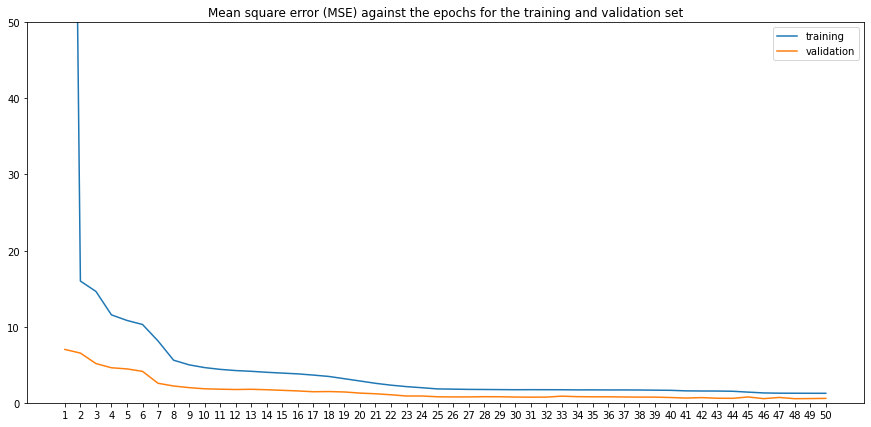

In [ ]:
# # Plot validation and training losses
# epochs = range(1, args.epochs+1)
# plt.figure(figsize=(15, 7))
# plt.title("Mean square error (MSE) against the epochs for the training and validation set")
# plt.plot(epochs, autoencoder.logs["train loss"], label="training")
# plt.plot(epochs, autoencoder.logs["val loss"], label="validation")
# plt.xticks(epochs)
# plt.ylim((0, 50))
# plt.legend(loc=1)
# plt.show()

In [ ]:
# # Examples of reconstructions on validation set
# n = 5
# idx = random.sample(range(len(test)), n)
# for i in idx:
#   example = test_tensor[i].to(args.device)
#   print("\nTarget")
#   print(example)
#   print("Reconstruction")
#   print(np.round(autoencoder.decoder(autoencoder.encoder(example)).detach().cpu().numpy()))



Target
tensor([ 5.,  5., 42.,  1.,  1.,  1.,  3.,  3.,  1.,  1.], device='cuda:0')
Reconstruction
[ 5.  5. 42.  1.  1.  1.  3.  3.  1.  1.]

Target
tensor([ 4.,  5., 31.,  1.,  6.,  2.,  2.,  3.,  1.,  0.], device='cuda:0')
Reconstruction
[ 4.  5. 31.  1.  6.  2.  2.  3.  1.  0.]

Target
tensor([ 6.,  2., 54.,  1.,  1.,  2.,  3.,  4.,  1.,  2.], device='cuda:0')
Reconstruction
[ 6.  2. 54.  1.  1.  1.  3.  4.  1.  2.]

Target
tensor([ 6.,  4., 15.,  1.,  0.,  2.,  3.,  2.,  1.,  0.], device='cuda:0')
Reconstruction
[ 6.  4. 15.  1.  0.  1.  3.  2.  1.  0.]

Target
tensor([ 5.,  4., 23.,  1.,  1.,  1.,  4.,  4.,  1.,  2.], device='cuda:0')
Reconstruction
[ 5.  4. 23.  1.  1.  1.  4.  4.  1.  2.]


### Save decoder

In [ ]:
# torch.save(autoencoder.decoder, "/content/gdrive/MyDrive/IFT6756/saved_models/decoder2.pt")

## Training WGAN (vanilla)

### Initialization

In [ ]:
args = Arguments_gan(epochs=25,
                     input_dim=10,
                     hidden_D=(64,),
                     hidden_G=(128,),
                     is_DP=False,
                     is_finetuning=True,
                     decoder=torch.load("/content/gdrive/MyDrive/IFT6756/saved_models/decoder2.pt"),
                     device="cuda",
                     verbose=False)

In [ ]:
# DataLoader
train_loader = DataLoader(train_tensor,
                              batch_size=args.batch_size,
                              shuffle=False)
val_loader = DataLoader(test_tensor,
                            batch_size=args.batch_size,
                            shuffle=False)

In [ ]:
# Model
gan = GAN(args)
gan.to(args.device)
print(gan)

GAN(
  (G): Generator(
    (decoder): Decoder(
      (input_layer): Linear(in_features=64, out_features=32, bias=True)
      (layers): ModuleList(
        (0): Linear(in_features=32, out_features=16, bias=True)
        (1): Linear(in_features=16, out_features=9, bias=True)
      )
      (output_layer): Linear(in_features=9, out_features=10, bias=True)
      (relu): ReLU()
    )
    (input_layer): Linear(in_features=100, out_features=128, bias=True)
    (input_activation): ReLU()
    (layers): ModuleList()
    (output_layer): Linear(in_features=128, out_features=64, bias=True)
    (output_activation): Tanh()
  )
  (D): Discriminator(
    (input_layer): Linear(in_features=10, out_features=64, bias=True)
    (input_activation): ReLU()
    (layers): ModuleList()
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)


### Training

In [ ]:
optimizer_D = torch.optim.RMSprop(gan.D.parameters(), args.lr)
optimizer_G = torch.optim.RMSprop(gan.G.parameters(), args.lr)
train_gan(gan, train_loader, optimizer_D, optimizer_G, args)

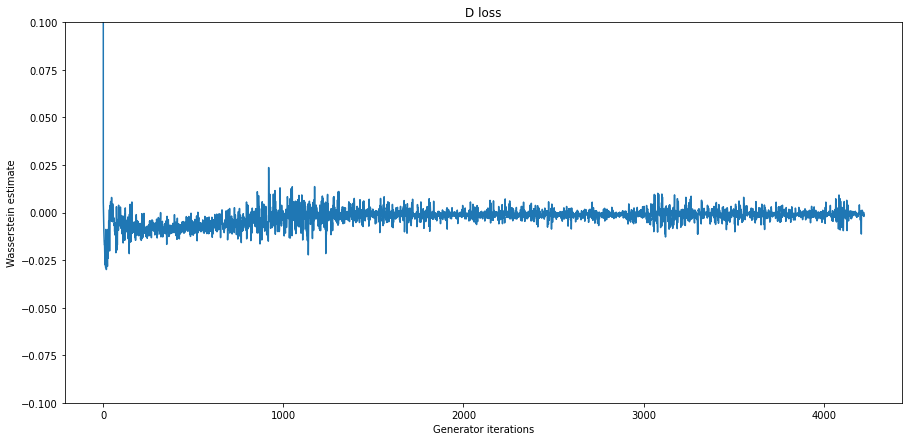

In [ ]:
plt.figure(figsize=(15, 7))
plt.title("D loss")
plt.xlabel("Generator iterations")
plt.ylabel("Wasserstein estimate")
plt.ylim([-0.1,0.1])
plt.plot(gan.logs["approx. EM distance"])
plt.show()

Il semble qu'on converge vraiment rapidement, les GANS ne sont peut-être pas les bons modèles pour cette tâche de génération.

### Compare the marginals

In [ ]:
batch_synthetic_df = pd.DataFrame(generate_samples(gan.G, train_df.shape[0], args), columns=train_df.columns)
batch_synthetic_df.head(10)

,HINCP,NP,AGEP,RAC1P,ESR,SEX,WIF,HUPAC,HHT,PUMA
0,1.0,2.0,59.0,0.0,5.0,1.0,1.0,2.0,2.0,4.0
1,4.0,4.0,53.0,1.0,2.0,1.0,3.0,2.0,1.0,2.0
2,6.0,4.0,0.0,3.0,3.0,2.0,3.0,1.0,1.0,0.0
3,3.0,1.0,38.0,1.0,2.0,1.0,2.0,4.0,2.0,3.0
4,4.0,1.0,60.0,1.0,2.0,1.0,2.0,3.0,1.0,0.0
5,5.0,3.0,28.0,2.0,3.0,2.0,3.0,4.0,1.0,0.0
6,3.0,5.0,36.0,2.0,0.0,2.0,3.0,3.0,2.0,0.0
7,3.0,3.0,62.0,2.0,0.0,1.0,2.0,3.0,2.0,0.0
8,5.0,3.0,27.0,1.0,0.0,1.0,2.0,2.0,2.0,3.0
9,2.0,4.0,45.0,1.0,0.0,1.0,2.0,3.0,2.0,2.0


In [ ]:
train_df.describe()

,HINCP,NP,AGEP,RAC1P,ESR,SEX,WIF,HUPAC,HHT,PUMA
count,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000
mean,4.359739,3.600355,38.095876,1.655142,2.024136,1.513882,2.781817,2.870067,1.336936,1.429259
std,1.294060,1.471551,22.889262,1.836128,2.272560,0.499826,0.836829,1.104323,0.711210,1.148630
min,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,3.000000,2.000000,17.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,0.000000
50%,5.000000,3.000000,39.000000,1.000000,1.000000,2.000000,3.000000,3.000000,1.000000,1.000000
75%,5.000000,4.000000,56.000000,1.000000,3.000000,2.000000,3.000000,4.000000,1.000000,2.000000
max,6.000000,13.000000,94.000000,9.000000,6.000000,2.000000,4.000000,4.000000,3.000000,3.000000


In [ ]:
batch_synthetic_df.describe()

,HINCP,NP,AGEP,RAC1P,ESR,SEX,WIF,HUPAC,HHT,PUMA
count,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000
mean,4.165026,3.482639,36.682240,1.674021,1.847709,1.436959,2.553639,2.849856,1.483675,1.404531
std,1.459671,1.564203,22.280342,0.810299,2.203785,0.496000,0.820381,1.134075,0.535774,1.854574
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,2.000000,20.000000,1.000000,0.000000,1.000000,2.000000,2.000000,1.000000,0.000000
50%,4.000000,3.000000,36.000000,2.000000,1.000000,1.000000,3.000000,3.000000,1.000000,0.000000
75%,5.000000,4.000000,52.000000,2.000000,3.000000,2.000000,3.000000,4.000000,2.000000,3.000000
max,10.000000,10.000000,131.000000,5.000000,13.000000,2.000000,6.000000,7.000000,3.000000,9.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


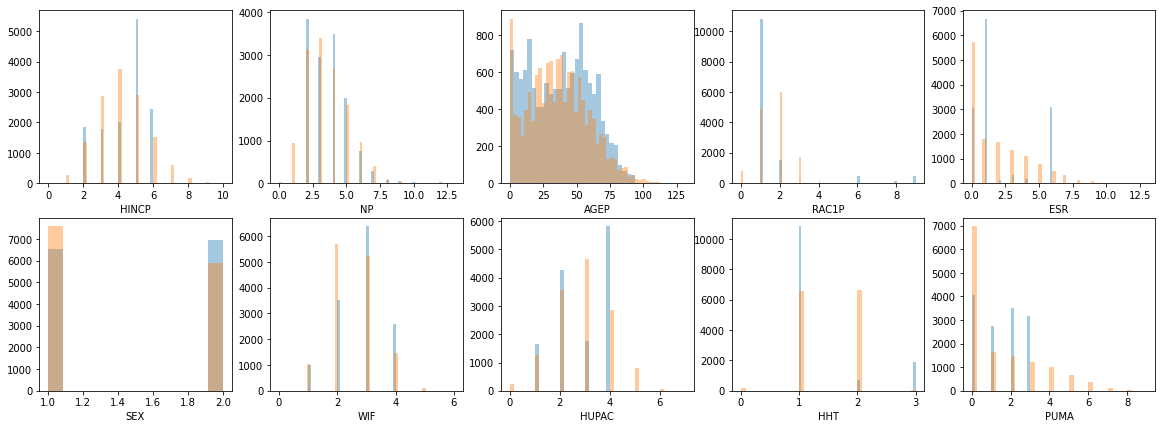

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
k = 0
col = train_df.columns
for i in range(2):
  for j in range(5):
    sns.distplot(train_df[col[k]], kde=False, ax=ax[i, j])
    sns.distplot(batch_synthetic_df[col[k]], kde=False, ax=ax[i, j])
    k += 1
plt.show()

## Training WGAN (with Differential privacy)

## Model 1, eps = 0.841

préférablement $\delta \leq 10^{-5}$.

Since the computation of $c_g$ is not trivial nor the implementation of the moment accountant method. We fall back on the **TensorFlow Privacy** library. 

we can use the `compute_dp_sgd_privacy` script to approximate the privacy loss $\epsilon$ for a given data set and training regime. `N` corresponds to the number of data points, and `noise_multiplier` corresponds to `sigma`. `batch_size` and `epochs` are the same as in training. `delta` is the tolerance probability for privacy loss beyond $\epsilon$.

In [ ]:
args01 = Arguments_gan(epochs=25,
                       batch_size=16,
                       input_dim=10,
                       hidden_D=(64,),
                       hidden_G=(128,),
                       is_DP=True,
                       sigma=1,
                       delta=10e-5,
                       is_finetuning=True,
                       decoder=torch.load("/content/gdrive/MyDrive/IFT6756/saved_models/decoder2.pt"),
                       device="cuda",
                       verbose=False)

In [ ]:
if args01.is_DP:
    print(compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=train.shape[0],
                                              batch_size=args01.batch_size,
                                              noise_multiplier=args01.sigma,
                                              epochs=args01.epochs,
                                              delta=args01.delta))

DP-SGD with sampling rate = 0.118% and noise_multiplier = 1 iterated over 21105 steps satisfies differential privacy with eps = 0.841 and delta = 0.0001.
The optimal RDP order is 12.0.
(0.8410069327133066, 12.0)


In [ ]:
# Model
gan01 = GAN(args01)
gan01.to(args01.device)

GAN(
  (G): Generator(
    (decoder): Decoder(
      (input_layer): Linear(in_features=64, out_features=32, bias=True)
      (layers): ModuleList(
        (0): Linear(in_features=32, out_features=16, bias=True)
        (1): Linear(in_features=16, out_features=9, bias=True)
      )
      (output_layer): Linear(in_features=9, out_features=10, bias=True)
      (relu): ReLU()
    )
    (input_layer): Linear(in_features=100, out_features=128, bias=True)
    (input_activation): ReLU()
    (layers): ModuleList()
    (output_layer): Linear(in_features=128, out_features=64, bias=True)
    (output_activation): Tanh()
  )
  (D): Discriminator(
    (input_layer): Linear(in_features=10, out_features=64, bias=True)
    (input_activation): ReLU()
    (layers): ModuleList()
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [ ]:
optimizer_D = torch.optim.RMSprop(gan01.D.parameters(), args01.lr)
optimizer_G = torch.optim.RMSprop(gan01.G.parameters(), args01.lr)
train_gan(gan01, train_loader, optimizer_D, optimizer_G, args01)

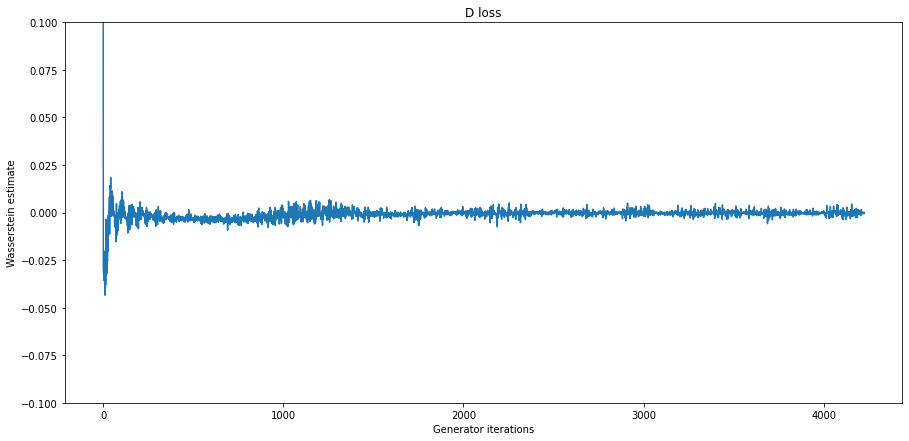

In [ ]:
plt.figure(figsize=(15, 7))
plt.title("D loss")
plt.xlabel("Generator iterations")
plt.ylabel("Wasserstein estimate")
plt.ylim([-0.1,0.1])
plt.plot(gan01.logs["approx. EM distance"])
plt.show()

In [ ]:
batch_synthetic01_df = pd.DataFrame(generate_samples(gan01.G, train_df.shape[0], args01), columns=train_df.columns)
batch_synthetic01_df.head(10)

,HINCP,NP,AGEP,RAC1P,ESR,SEX,WIF,HUPAC,HHT,PUMA
0,3.0,3.0,81.0,1.0,6.0,1.0,4.0,3.0,0.0,3.0
1,4.0,6.0,63.0,2.0,1.0,1.0,4.0,3.0,1.0,0.0
2,5.0,5.0,63.0,2.0,1.0,1.0,4.0,3.0,0.0,1.0
3,6.0,2.0,21.0,1.0,0.0,1.0,3.0,1.0,1.0,2.0
4,5.0,4.0,88.0,1.0,4.0,1.0,4.0,3.0,0.0,3.0
5,4.0,2.0,30.0,2.0,4.0,2.0,2.0,3.0,1.0,1.0
6,5.0,3.0,13.0,3.0,0.0,2.0,2.0,2.0,2.0,0.0
7,4.0,7.0,37.0,3.0,4.0,2.0,3.0,3.0,1.0,0.0
8,5.0,3.0,29.0,1.0,4.0,1.0,2.0,4.0,1.0,4.0
9,4.0,3.0,30.0,2.0,2.0,2.0,2.0,4.0,2.0,0.0


In [ ]:
train_df.describe()

,HINCP,NP,AGEP,RAC1P,ESR,SEX,WIF,HUPAC,HHT,PUMA
count,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000
mean,4.359739,3.600355,38.095876,1.655142,2.024136,1.513882,2.781817,2.870067,1.336936,1.429259
std,1.294060,1.471551,22.889262,1.836128,2.272560,0.499826,0.836829,1.104323,0.711210,1.148630
min,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,3.000000,2.000000,17.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,0.000000
50%,5.000000,3.000000,39.000000,1.000000,1.000000,2.000000,3.000000,3.000000,1.000000,1.000000
75%,5.000000,4.000000,56.000000,1.000000,3.000000,2.000000,3.000000,4.000000,1.000000,2.000000
max,6.000000,13.000000,94.000000,9.000000,6.000000,2.000000,4.000000,4.000000,3.000000,3.000000


In [ ]:
batch_synthetic01_df.describe()

,HINCP,NP,AGEP,RAC1P,ESR,SEX,WIF,HUPAC,HHT,PUMA
count,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000
mean,4.528689,3.292515,40.473827,1.727327,1.876286,1.364848,2.968239,2.861183,1.039757,1.327090
std,1.490332,1.327408,19.768509,0.696629,2.009328,0.481987,0.716474,0.916160,0.746222,1.575896
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,4.000000,2.000000,26.000000,1.000000,0.000000,1.000000,3.000000,2.000000,0.000000,0.000000
50%,4.000000,3.000000,40.000000,2.000000,1.000000,1.000000,3.000000,3.000000,1.000000,1.000000
75%,5.000000,4.000000,54.000000,2.000000,3.000000,2.000000,3.000000,3.000000,2.000000,2.000000
max,11.000000,10.000000,113.000000,4.000000,11.000000,3.000000,6.000000,6.000000,3.000000,8.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


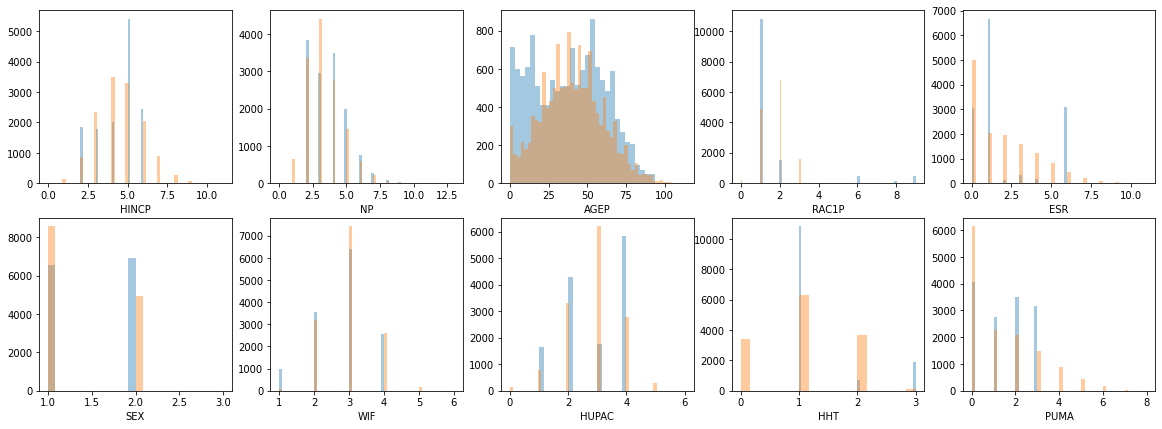

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
k = 0
col = train_df.columns
for i in range(2):
  for j in range(5):
    sns.distplot(train_df[col[k]], kde=False, ax=ax[i, j])
    sns.distplot(batch_synthetic01_df[col[k]], kde=False, ax=ax[i, j])
    k += 1
plt.show()

### Model 2, eps = 7.56

In [ ]:
args02 = Arguments_gan(epochs=25,
                       batch_size=16,
                       input_dim=10,
                       hidden_D=(64,),
                       hidden_G=(128,),
                       is_DP=True,
                       sigma=0.5,
                       delta=10e-5,
                       is_finetuning=True,
                       decoder=torch.load("/content/gdrive/MyDrive/IFT6756/saved_models/decoder2.pt"),
                       device="cuda",
                       verbose=False)

In [ ]:
if args02.is_DP:
    print(compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=train.shape[0],
                                              batch_size=args02.batch_size,
                                              noise_multiplier=args02.sigma,
                                              epochs=args02.epochs,
                                              delta=args02.delta))

DP-SGD with sampling rate = 0.118% and noise_multiplier = 0.5 iterated over 21105 steps satisfies differential privacy with eps = 7.56 and delta = 0.0001.
The optimal RDP order is 2.5.
(7.562537930730513, 2.5)


In [ ]:
# Model
gan02 = GAN(args02)
gan02.to(args02.device)

GAN(
  (G): Generator(
    (decoder): Decoder(
      (input_layer): Linear(in_features=64, out_features=32, bias=True)
      (layers): ModuleList(
        (0): Linear(in_features=32, out_features=16, bias=True)
        (1): Linear(in_features=16, out_features=9, bias=True)
      )
      (output_layer): Linear(in_features=9, out_features=10, bias=True)
      (relu): ReLU()
    )
    (input_layer): Linear(in_features=100, out_features=128, bias=True)
    (input_activation): ReLU()
    (layers): ModuleList()
    (output_layer): Linear(in_features=128, out_features=64, bias=True)
    (output_activation): Tanh()
  )
  (D): Discriminator(
    (input_layer): Linear(in_features=10, out_features=64, bias=True)
    (input_activation): ReLU()
    (layers): ModuleList()
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [ ]:
optimizer_D = torch.optim.RMSprop(gan02.D.parameters(), args02.lr)
optimizer_G = torch.optim.RMSprop(gan02.G.parameters(), args02.lr)
train_gan(gan02, train_loader, optimizer_D, optimizer_G, args02)

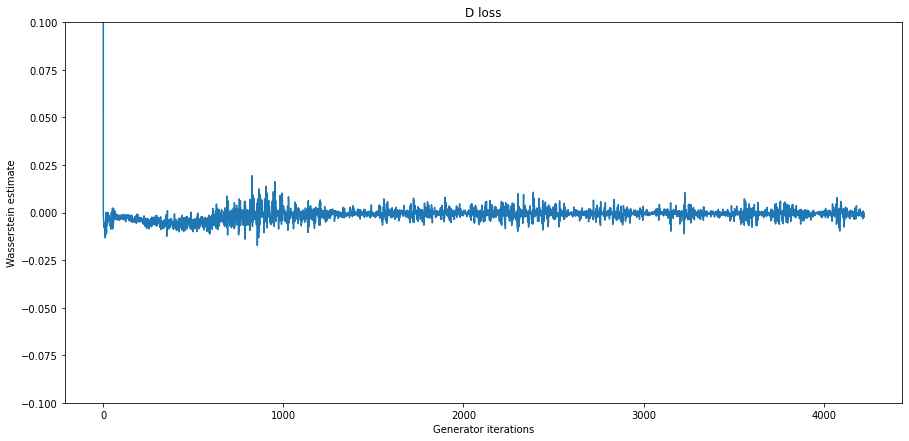

In [ ]:
plt.figure(figsize=(15, 7))
plt.title("D loss")
plt.xlabel("Generator iterations")
plt.ylabel("Wasserstein estimate")
plt.ylim([-0.1,0.1])
plt.plot(gan02.logs["approx. EM distance"])
plt.show()

In [ ]:
batch_synthetic02_df = pd.DataFrame(generate_samples(gan02.G, train_df.shape[0], args02), columns=train_df.columns)
batch_synthetic02_df.head(10)

,HINCP,NP,AGEP,RAC1P,ESR,SEX,WIF,HUPAC,HHT,PUMA
0,5.0,2.0,21.0,2.0,0.0,2.0,2.0,2.0,1.0,0.0
1,4.0,2.0,31.0,2.0,1.0,1.0,2.0,3.0,2.0,0.0
2,6.0,5.0,38.0,1.0,0.0,2.0,3.0,1.0,1.0,2.0
3,5.0,5.0,24.0,2.0,2.0,2.0,4.0,3.0,1.0,0.0
4,6.0,4.0,74.0,0.0,1.0,2.0,3.0,2.0,1.0,3.0
5,4.0,1.0,23.0,1.0,0.0,2.0,2.0,2.0,1.0,0.0
6,6.0,4.0,24.0,2.0,0.0,2.0,3.0,1.0,1.0,0.0
7,6.0,6.0,18.0,3.0,0.0,2.0,4.0,3.0,1.0,0.0
8,4.0,1.0,35.0,1.0,3.0,2.0,2.0,3.0,1.0,3.0
9,2.0,5.0,24.0,2.0,0.0,2.0,3.0,1.0,2.0,0.0


In [ ]:
train_df.describe()

,HINCP,NP,AGEP,RAC1P,ESR,SEX,WIF,HUPAC,HHT,PUMA
count,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000
mean,4.359739,3.600355,38.095876,1.655142,2.024136,1.513882,2.781817,2.870067,1.336936,1.429259
std,1.294060,1.471551,22.889262,1.836128,2.272560,0.499826,0.836829,1.104323,0.711210,1.148630
min,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,3.000000,2.000000,17.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,0.000000
50%,5.000000,3.000000,39.000000,1.000000,1.000000,2.000000,3.000000,3.000000,1.000000,1.000000
75%,5.000000,4.000000,56.000000,1.000000,3.000000,2.000000,3.000000,4.000000,1.000000,2.000000
max,6.000000,13.000000,94.000000,9.000000,6.000000,2.000000,4.000000,4.000000,3.000000,3.000000


In [ ]:
batch_synthetic02_df.describe()

,HINCP,NP,AGEP,RAC1P,ESR,SEX,WIF,HUPAC,HHT,PUMA
count,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000
mean,4.542830,3.655956,38.234177,1.542904,1.878433,1.795513,2.820019,2.716962,1.335011,1.423854
std,1.627145,1.628455,21.125198,0.923738,2.284348,0.403354,0.705645,0.944739,0.569683,1.919895
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,3.000000,2.000000,23.000000,1.000000,0.000000,2.000000,2.000000,2.000000,1.000000,0.000000
50%,4.000000,3.000000,38.000000,2.000000,1.000000,2.000000,3.000000,3.000000,1.000000,0.000000
75%,6.000000,5.000000,53.000000,2.000000,3.000000,2.000000,3.000000,3.000000,2.000000,3.000000
max,11.000000,11.000000,116.000000,5.000000,13.000000,2.000000,6.000000,6.000000,3.000000,10.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


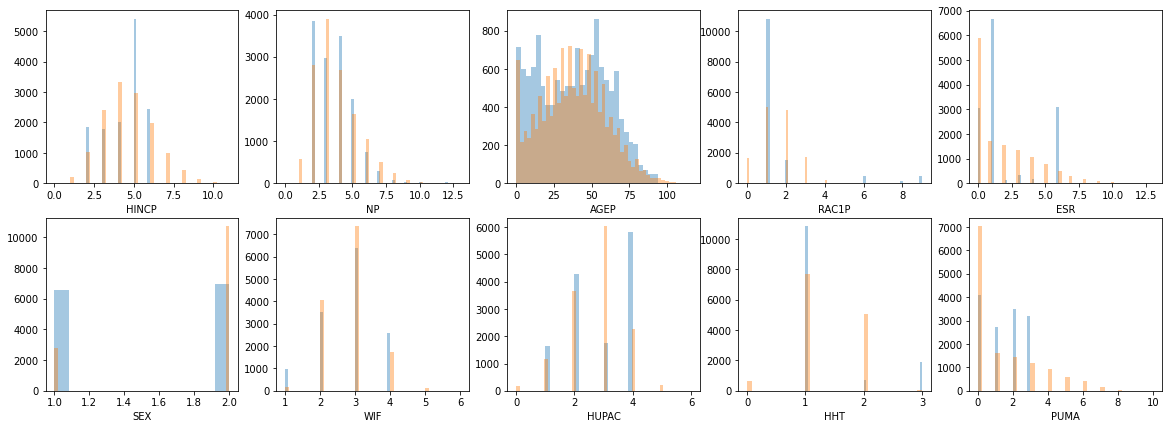

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
k = 0
col = train_df.columns
for i in range(2):
  for j in range(5):
    sns.distplot(train_df[col[k]], kde=False, ax=ax[i, j])
    sns.distplot(batch_synthetic02_df[col[k]], kde=False, ax=ax[i, j])
    k += 1
plt.show()

## Model 3, eps = 19.7

In [ ]:
args03 = Arguments_gan(epochs=25,
                       batch_size=16,
                       input_dim=10,
                       hidden_D=(64,),
                       hidden_G=(128,),
                       is_DP=True,
                       sigma=0.4,
                       delta=10e-5,
                       is_finetuning=True,
                       decoder=torch.load("/content/gdrive/MyDrive/IFT6756/saved_models/decoder2.pt"),
                       device="cuda",
                       verbose=False)

In [ ]:
if args03.is_DP:
    print(compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=train.shape[0],
                                              batch_size=args03.batch_size,
                                              noise_multiplier=args03.sigma,
                                              epochs=args03.epochs,
                                              delta=args03.delta))

DP-SGD with sampling rate = 0.118% and noise_multiplier = 0.4 iterated over 21105 steps satisfies differential privacy with eps = 19.7 and delta = 0.0001.
The optimal RDP order is 1.75.
(19.658544032651683, 1.75)


In [ ]:
# Model
gan03 = GAN(args03)
gan03.to(args03.device)

GAN(
  (G): Generator(
    (decoder): Decoder(
      (input_layer): Linear(in_features=64, out_features=32, bias=True)
      (layers): ModuleList(
        (0): Linear(in_features=32, out_features=16, bias=True)
        (1): Linear(in_features=16, out_features=9, bias=True)
      )
      (output_layer): Linear(in_features=9, out_features=10, bias=True)
      (relu): ReLU()
    )
    (input_layer): Linear(in_features=100, out_features=128, bias=True)
    (input_activation): ReLU()
    (layers): ModuleList()
    (output_layer): Linear(in_features=128, out_features=64, bias=True)
    (output_activation): Tanh()
  )
  (D): Discriminator(
    (input_layer): Linear(in_features=10, out_features=64, bias=True)
    (input_activation): ReLU()
    (layers): ModuleList()
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [ ]:
optimizer_D = torch.optim.RMSprop(gan03.D.parameters(), args03.lr)
optimizer_G = torch.optim.RMSprop(gan03.G.parameters(), args03.lr)
train_gan(gan03, train_loader, optimizer_D, optimizer_G, args03)

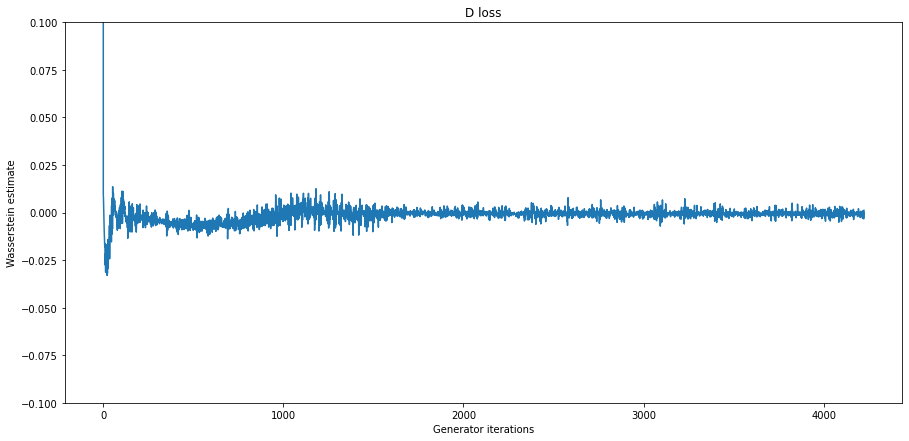

In [ ]:
plt.figure(figsize=(15, 7))
plt.title("D loss")
plt.xlabel("Generator iterations")
plt.ylabel("Wasserstein estimate")
plt.ylim([-0.1,0.1])
plt.plot(gan03.logs["approx. EM distance"])
plt.show()

In [ ]:
batch_synthetic03_df = pd.DataFrame(generate_samples(gan03.G, train_df.shape[0], args03), columns=train_df.columns)
batch_synthetic03_df.head(10)

,HINCP,NP,AGEP,RAC1P,ESR,SEX,WIF,HUPAC,HHT,PUMA
0,5.0,2.0,48.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0
1,4.0,2.0,40.0,1.0,0.0,1.0,3.0,3.0,1.0,1.0
2,5.0,3.0,50.0,2.0,0.0,1.0,2.0,3.0,2.0,0.0
3,2.0,6.0,19.0,3.0,3.0,2.0,4.0,4.0,1.0,0.0
4,4.0,4.0,21.0,2.0,0.0,2.0,3.0,3.0,2.0,1.0
5,4.0,5.0,23.0,1.0,0.0,2.0,4.0,2.0,1.0,5.0
6,5.0,5.0,38.0,2.0,7.0,2.0,3.0,5.0,1.0,3.0
7,6.0,5.0,0.0,2.0,0.0,2.0,3.0,2.0,2.0,4.0
8,2.0,3.0,63.0,0.0,5.0,1.0,2.0,3.0,1.0,5.0
9,4.0,2.0,45.0,1.0,3.0,1.0,2.0,4.0,1.0,2.0


In [ ]:
test_df.describe()

,HINCP,NP,AGEP,RAC1P,ESR,SEX,WIF,HUPAC,HHT,PUMA
count,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000,5790.000000
mean,4.389292,3.620207,38.029188,1.659585,1.989810,1.509845,2.778584,2.870466,1.313126,1.426252
std,1.283628,1.506813,22.661699,1.840789,2.245065,0.499946,0.838294,1.098756,0.691146,1.135949
min,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,3.000000,2.000000,17.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,0.000000
50%,5.000000,3.000000,39.000000,1.000000,1.000000,2.000000,3.000000,3.000000,1.000000,1.000000
75%,5.000000,4.000000,56.000000,1.000000,3.000000,2.000000,3.000000,4.000000,1.000000,2.000000
max,6.000000,13.000000,94.000000,9.000000,6.000000,2.000000,4.000000,4.000000,3.000000,3.000000


In [ ]:
batch_synthetic03_df.describe()

,HINCP,NP,AGEP,RAC1P,ESR,SEX,WIF,HUPAC,HHT,PUMA
count,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000,13507.000000
mean,4.494040,3.595617,40.691936,1.647812,2.104464,1.331458,2.659288,2.745761,1.285334,1.387059
std,1.590921,1.573476,20.155624,1.126184,2.387566,0.471072,0.762856,0.977580,0.581440,1.830942
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,3.000000,2.000000,26.000000,1.000000,0.000000,1.000000,2.000000,2.000000,1.000000,0.000000
50%,4.000000,3.000000,40.000000,2.000000,1.000000,1.000000,3.000000,3.000000,1.000000,0.000000
75%,6.000000,5.000000,55.000000,2.000000,4.000000,2.000000,3.000000,3.000000,2.000000,2.000000
max,12.000000,10.000000,110.000000,6.000000,13.000000,3.000000,6.000000,6.000000,3.000000,9.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


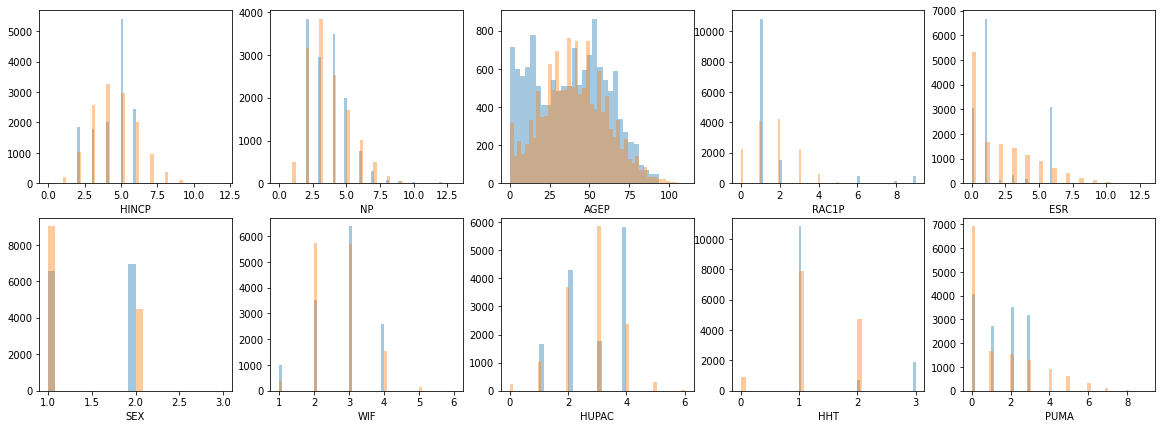

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
k = 0
col = train_df.columns
for i in range(2):
  for j in range(5):
    sns.distplot(train_df[col[k]], kde=False, ax=ax[i, j])
    sns.distplot(batch_synthetic03_df[col[k]], kde=False, ax=ax[i, j])
    k += 1
plt.show()

## Model Evaluation

### Dimension-wise prediction

After training the model with real training dataset to generate synthetic population, we choose one dimension to be the label. The remaining dimensions are used as features to train two classifier with same hyperparameters to predict the isolated dimension. Then, we use the two classifiers to predict de test set. We can assume that the closer the performance of the classifiers, the better the quality of the synthetic samples.
(https://arxiv.org/pdf/1703.06490.pdf)

In [ ]:
f1_scores = []
f1_scores01 = []
f1_scores02 = []
f1_scores03 = []
for col in train_df.columns:
    f1_scores.append(DWP(train_df, batch_synthetic_df, test_df, col))
    f1_scores01.append(DWP(train_df, batch_synthetic01_df, test_df, col))
    f1_scores02.append(DWP(train_df, batch_synthetic02_df, test_df, col))
    f1_scores03.append(DWP(train_df, batch_synthetic03_df, test_df, col))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [58]:
for i, f1 in enumerate(f1_scores):
    f1_real, f1_synthetic = f1
    print(f"Dim:{train_df.columns[i]},\t F1 real: {f1_real:.3f},\t F1 vanilla: {f1_synthetic:.3f},\t F1 01: {f1_scores01[i][1]:.3f},\t F1 02: {f1_scores02[i][1]:.3f},\t F1 03: {f1_scores03[i][1]:.3f}")

Dim:HINCP,	 F1 real: 0.316,	 F1 vanilla: 0.301,	 F1 01: 0.172,	 F1 02: 0.273,	 F1 03: 0.286
Dim:NP,	 F1 real: 0.409,	 F1 vanilla: 0.265,	 F1 01: 0.161,	 F1 02: 0.216,	 F1 03: 0.152
Dim:AGEP,	 F1 real: 0.042,	 F1 vanilla: 0.010,	 F1 01: 0.008,	 F1 02: 0.009,	 F1 03: 0.009
Dim:RAC1P,	 F1 real: 0.716,	 F1 vanilla: 0.531,	 F1 01: 0.422,	 F1 02: 0.464,	 F1 03: 0.414
Dim:ESR,	 F1 real: 0.803,	 F1 vanilla: 0.161,	 F1 01: 0.315,	 F1 02: 0.354,	 F1 03: 0.252
Dim:SEX,	 F1 real: 0.541,	 F1 vanilla: 0.503,	 F1 01: 0.498,	 F1 02: 0.448,	 F1 03: 0.490
Dim:WIF,	 F1 real: 0.560,	 F1 vanilla: 0.472,	 F1 01: 0.452,	 F1 02: 0.432,	 F1 03: 0.460
Dim:HUPAC,	 F1 real: 0.638,	 F1 vanilla: 0.444,	 F1 01: 0.272,	 F1 02: 0.152,	 F1 03: 0.148
Dim:HHT,	 F1 real: 0.759,	 F1 vanilla: 0.646,	 F1 01: 0.512,	 F1 02: 0.643,	 F1 03: 0.648
Dim:PUMA,	 F1 real: 0.326,	 F1 vanilla: 0.212,	 F1 01: 0.219,	 F1 02: 0.200,	 F1 03: 0.186


## Considérations sur la confidentialité

### Attribute disclosure

On échantillonne $m$ exemples de l'ensemble d'entraînement. Pour chaque exemple $r$, on suppose que l'attaquant ne connait pas $s$ attributs déterminés aléatoirement. 

L'attaquant essaie de retrouver les attributs inconnnus de $r$ de la façon suivante. Il trouve les $k$ plus proche voisins de $r$ dans l'ensemble de données synthétiques. Les attributs inconnus de $r$ sont estimés par un vote majoritaire des attributs des $k$ plus proches voisins. Pour évaluer la classification, on compte simplement le nombre d'erreurs.

Ce processus est répété pour les $m$ exemples de l'ensemble d'entraînement. On détermine ainsi le ratio d'éléments retrouvés par rapport au nombre total d'éléments qu'on voulait retrouvé (accuracy). Notons que $s$ attributs sont choisis aléatoirement pour chaque exemple. L'attaquant peut connaître différents attributs $s$ pour différents exemples.

#### Impact du nombre d'attributs connus

Training set

In [59]:
print(f"Nombre total d'attributs: {train_df.columns.shape[0]}")

Nombre total d'attributs: 10


In [60]:
total_attributes = train_df.columns.shape[0]
m = 100
n_neighbhors = [1, 5, 10, 100]
n_attributes = [1, 2, 3, 4, 5, 6, 7, 8, 9]  # to be guess
acc = {}
for k in n_neighbhors:
    acc[k] = []
    for s in n_attributes:
        n_guessed_attributes = s * m
        n_errors = attribute_disclosure(train_df, train_df, m, s, k)
        acc[k].append(1 - n_errors/n_guessed_attributes)

Pour un nombre fixe de données synthétiques. On trace la courbe de l'accuracy (pourcentage d'attributs effectivement retrouvés)

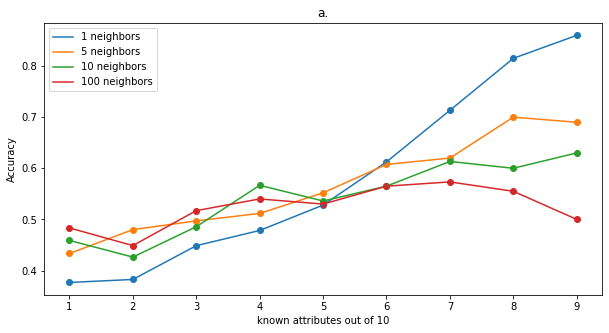

In [61]:
known_attributes = [total_attributes - s for s in n_attributes]
plt.figure(figsize=(10,5))
for key, item in acc.items():
    plt.plot(known_attributes, item, label=f"{key} neighbors")
    plt.scatter(known_attributes, item)
plt.xticks = known_attributes
plt.title("a.")
plt.xlabel(f"known attributes out of {total_attributes}")
plt.ylabel(f"Accuracy")
plt.legend(loc=0)
plt.show()

Model vanilla

In [62]:
total_attributes = train_df.columns.shape[0]
m = 100
n_neighbhors = [1, 5, 10, 100]
n_attributes = [1, 2, 3, 4, 5, 6, 7, 8, 9]  # to be guessed
acc = {}
for k in n_neighbhors:
    acc[k] = []
    for s in n_attributes:
        n_guessed_attributes = s * m
        n_errors = attribute_disclosure(train_df, batch_synthetic_df, m, s, k)
        acc[k].append(1 - n_errors/n_guessed_attributes)

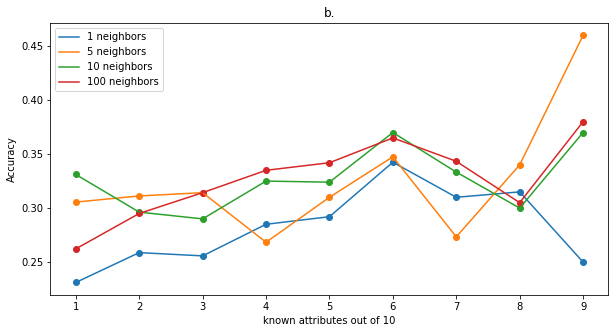

In [63]:
known_attributes = [total_attributes - s for s in n_attributes]
plt.figure(figsize=(10,5))
for key, item in acc.items():
    plt.plot(known_attributes, item, label=f"{key} neighbors")
    plt.scatter(known_attributes, item)
plt.xticks = known_attributes
plt.title("b.")
plt.xlabel(f"known attributes out of {total_attributes}")
plt.ylabel(f"Accuracy")
plt.legend(loc=0)
plt.show()

Model 1, esp = 0.84

In [64]:
total_attributes = train_df.columns.shape[0]
m = 100
n_neighbhors = [1, 5, 10, 100]
n_attributes = [1, 2, 3, 4, 5, 6, 7, 8, 9]  # to be guessed
acc = {}
for k in n_neighbhors:
    acc[k] = []
    for s in n_attributes:
        n_guessed_attributes = s * m
        n_errors = attribute_disclosure(train_df, batch_synthetic01_df, m, s, k)
        acc[k].append(1 - n_errors/n_guessed_attributes)

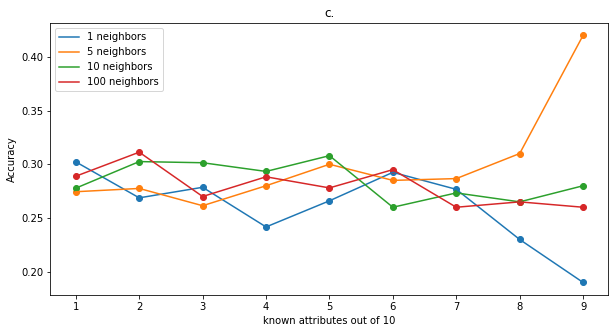

In [65]:
known_attributes = [total_attributes - s for s in n_attributes]
plt.figure(figsize=(10,5))
for key, item in acc.items():
    plt.plot(known_attributes, item, label=f"{key} neighbors")
    plt.scatter(known_attributes, item)
plt.xticks = known_attributes
plt.title("c.")
plt.xlabel(f"known attributes out of {total_attributes}")
plt.ylabel(f"Accuracy")
plt.legend(loc=0)
plt.show()

Model 2, esp = 7.56

In [66]:
total_attributes = train_df.columns.shape[0]
m = 100
n_neighbhors = [1, 5, 10, 100]
n_attributes = [1, 2, 3, 4, 5, 6, 7, 8, 9]  # to be guessed
acc = {}
for k in n_neighbhors:
    acc[k] = []
    for s in n_attributes:
        n_guessed_attributes = s * m
        n_errors = attribute_disclosure(train_df, batch_synthetic02_df, m, s, k)
        acc[k].append(1 - n_errors/n_guessed_attributes)

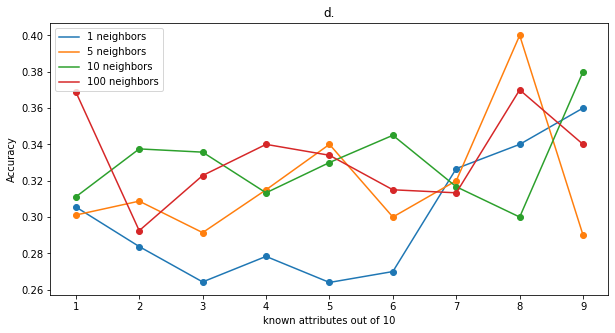

In [67]:
known_attributes = [total_attributes - s for s in n_attributes]
plt.figure(figsize=(10,5))
for key, item in acc.items():
    plt.plot(known_attributes, item, label=f"{key} neighbors")
    plt.scatter(known_attributes, item)
plt.xticks = known_attributes
plt.title("d.")
plt.xlabel(f"known attributes out of {total_attributes}")
plt.ylabel(f"Accuracy")
plt.legend(loc=0)
plt.show()

Model 3, eps = 19.7

In [72]:
total_attributes = train_df.columns.shape[0]
m = 100
n_neighbhors = [1, 5, 10, 100]
n_attributes = [1, 2, 3, 4, 5, 6, 7, 8, 9]  # to be guessed
acc = {}
for k in n_neighbhors:
    acc[k] = []
    for s in n_attributes:
        n_guessed_attributes = s * m
        n_errors = attribute_disclosure(train_df, batch_synthetic02_df, m, s, k)
        acc[k].append(1 - n_errors/n_guessed_attributes)

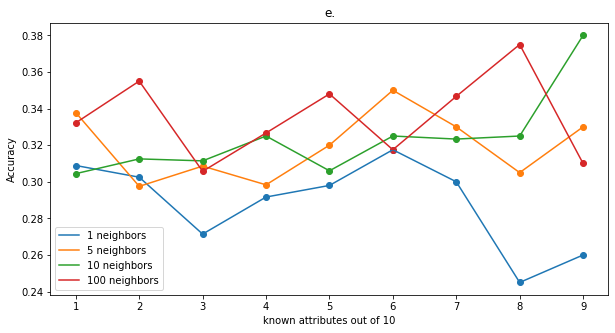

In [73]:
known_attributes = [total_attributes - s for s in n_attributes]
plt.figure(figsize=(10,5))
for key, item in acc.items():
    plt.plot(known_attributes, item, label=f"{key} neighbors")
    plt.scatter(known_attributes, item)
plt.xticks = known_attributes
plt.title("e.")
plt.xlabel(f"known attributes out of {total_attributes}")
plt.ylabel(f"Accuracy")
plt.show()